# Flat Gaussian with compositional score matching using GAUSS


In this notebook, we will use the compositional score matching to learn the posterior of a flat Gaussian model.
The problem is defined as follows:
- The prior is a Gaussian distribution with mean 0 and standard deviation 0.1.
- The simulator/likelihood is a Gaussian distribution with mean 0 and standard deviation 0.1.
- We have an analytical solution for the posterior.
- We set the dimension of the problem to $D=10$.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from problems.gaussian_flat import Prior, generate_synthetic_data
from tqdm import tqdm

import torch
from torch.distributions import MultivariateNormal
from sbi.inference import NPSE

In [2]:
D = 10  # The dimensionality of the Gaussian prior distribution.
scale = 0.1  # The scale of the Gaussian prior.
torch_device = torch.device('cpu')

In [3]:
prior_sbi = MultivariateNormal(loc=torch.zeros(D, device=torch_device), scale_tril=torch.eye(D, device=torch_device)*scale)
simulator_sbi = lambda theta: MultivariateNormal(loc=theta, scale_tril=torch.eye(D, device=torch_device)*scale).sample()

In [4]:
theta_train_valid = prior_sbi.sample((11000,))
x_train_valid = simulator_sbi(theta_train_valid)
x_train_valid.shape

torch.Size([11000, 10])

In [5]:
# Instantiate NPSE and append simulations
inference = NPSE(prior=prior_sbi, sde_type="vp", vf_estimator='mlp', hidden_features=256, num_layers=5,
                 time_emb_type='random_fourier', time_emb_features=8, device=torch_device)  # same settings as in the ScoreModel
inference.append_simulations(theta_train_valid, x_train_valid)

# Train the score estimator
score_estimator = inference.train(  # same settings as in train_score_model
    training_batch_size=128,
    learning_rate=5e-4,
    validation_fraction=1000/11000,
    max_num_epochs=1000,
    stop_after_epochs=1000,
    clip_max_norm=None,
)

 Training neural network. Epochs trained: 1001

In [6]:
tall_posterior = inference.build_posterior(score_estimator, prior=prior_sbi, sample_with="sde")

In [7]:
def tall_data_sampling(data, n_samples, show_progress_bars=False):
    tall_samples = np.zeros((len(data), n_samples, D))
    for i, d in tqdm(enumerate(data), total=len(data)):
        # Sample from a posterior conditioned with multiple observations
        tall_samples_d = tall_posterior.sample(sample_shape=(n_samples,), x=d,  iid_method="auto_gauss",
                                               show_progress_bars=show_progress_bars)
        tall_samples[i, :] = tall_samples_d.numpy()
    return tall_samples

# Validation

In [8]:
data_size = 10  # number of observations
prior = Prior()
param_names = ['$D_{' + str(i+1) + '}$' for i in range(prior.D)]
n_post_samples = 100
valid_prior_global, valid_data = generate_synthetic_data(prior, n_samples=1, data_size=data_size,
                                                             normalize=False, random_seed=0)

In [9]:
posterior_global_samples_valid = tall_data_sampling(valid_data, n_samples=n_post_samples, show_progress_bars=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating 100 posterior samples in 499 diffusion steps.:   0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:18<00:00, 18.33s/it]


In [10]:
from bayesflow import diagnostics

When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


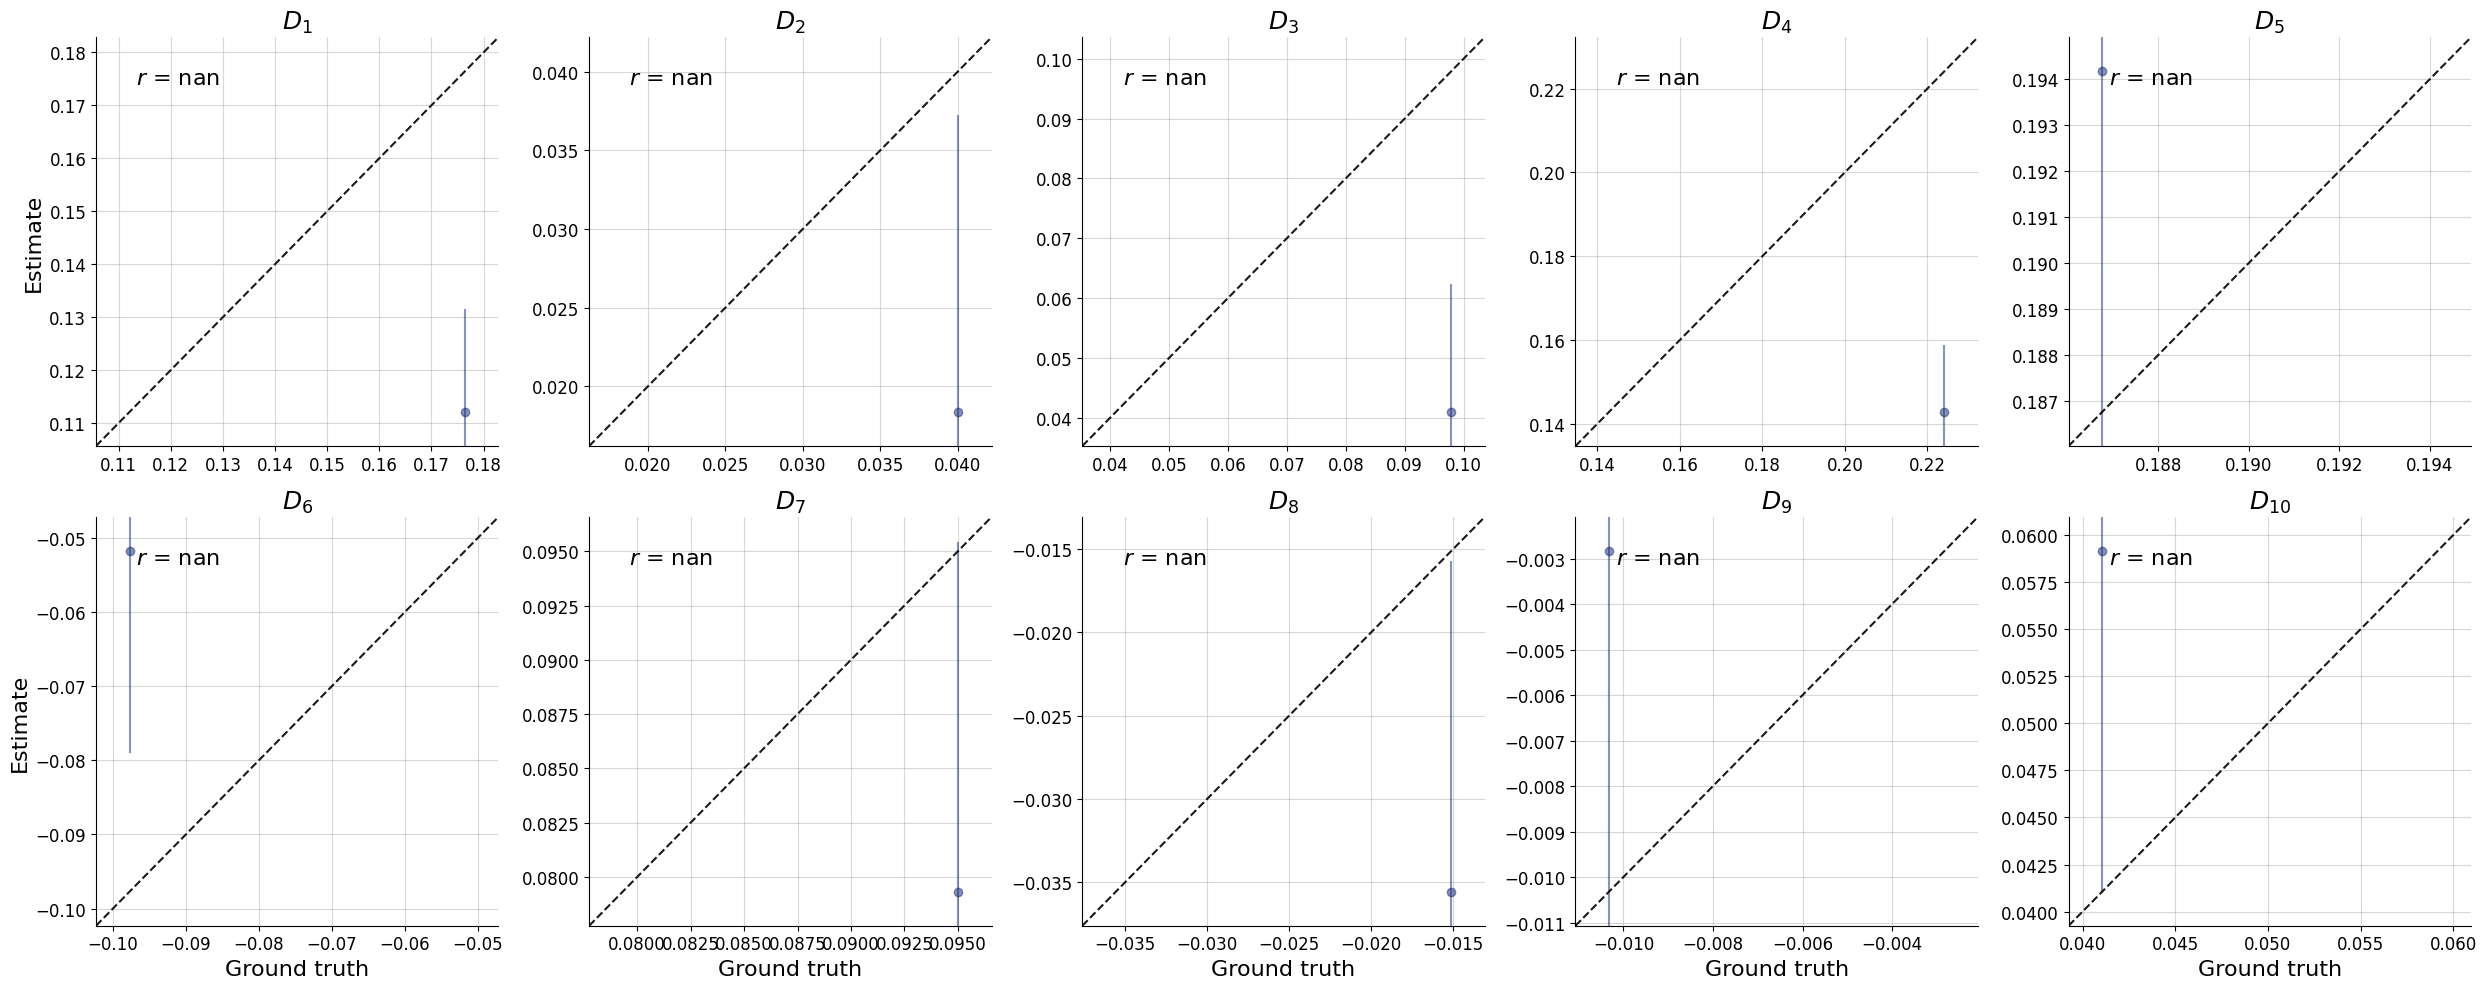

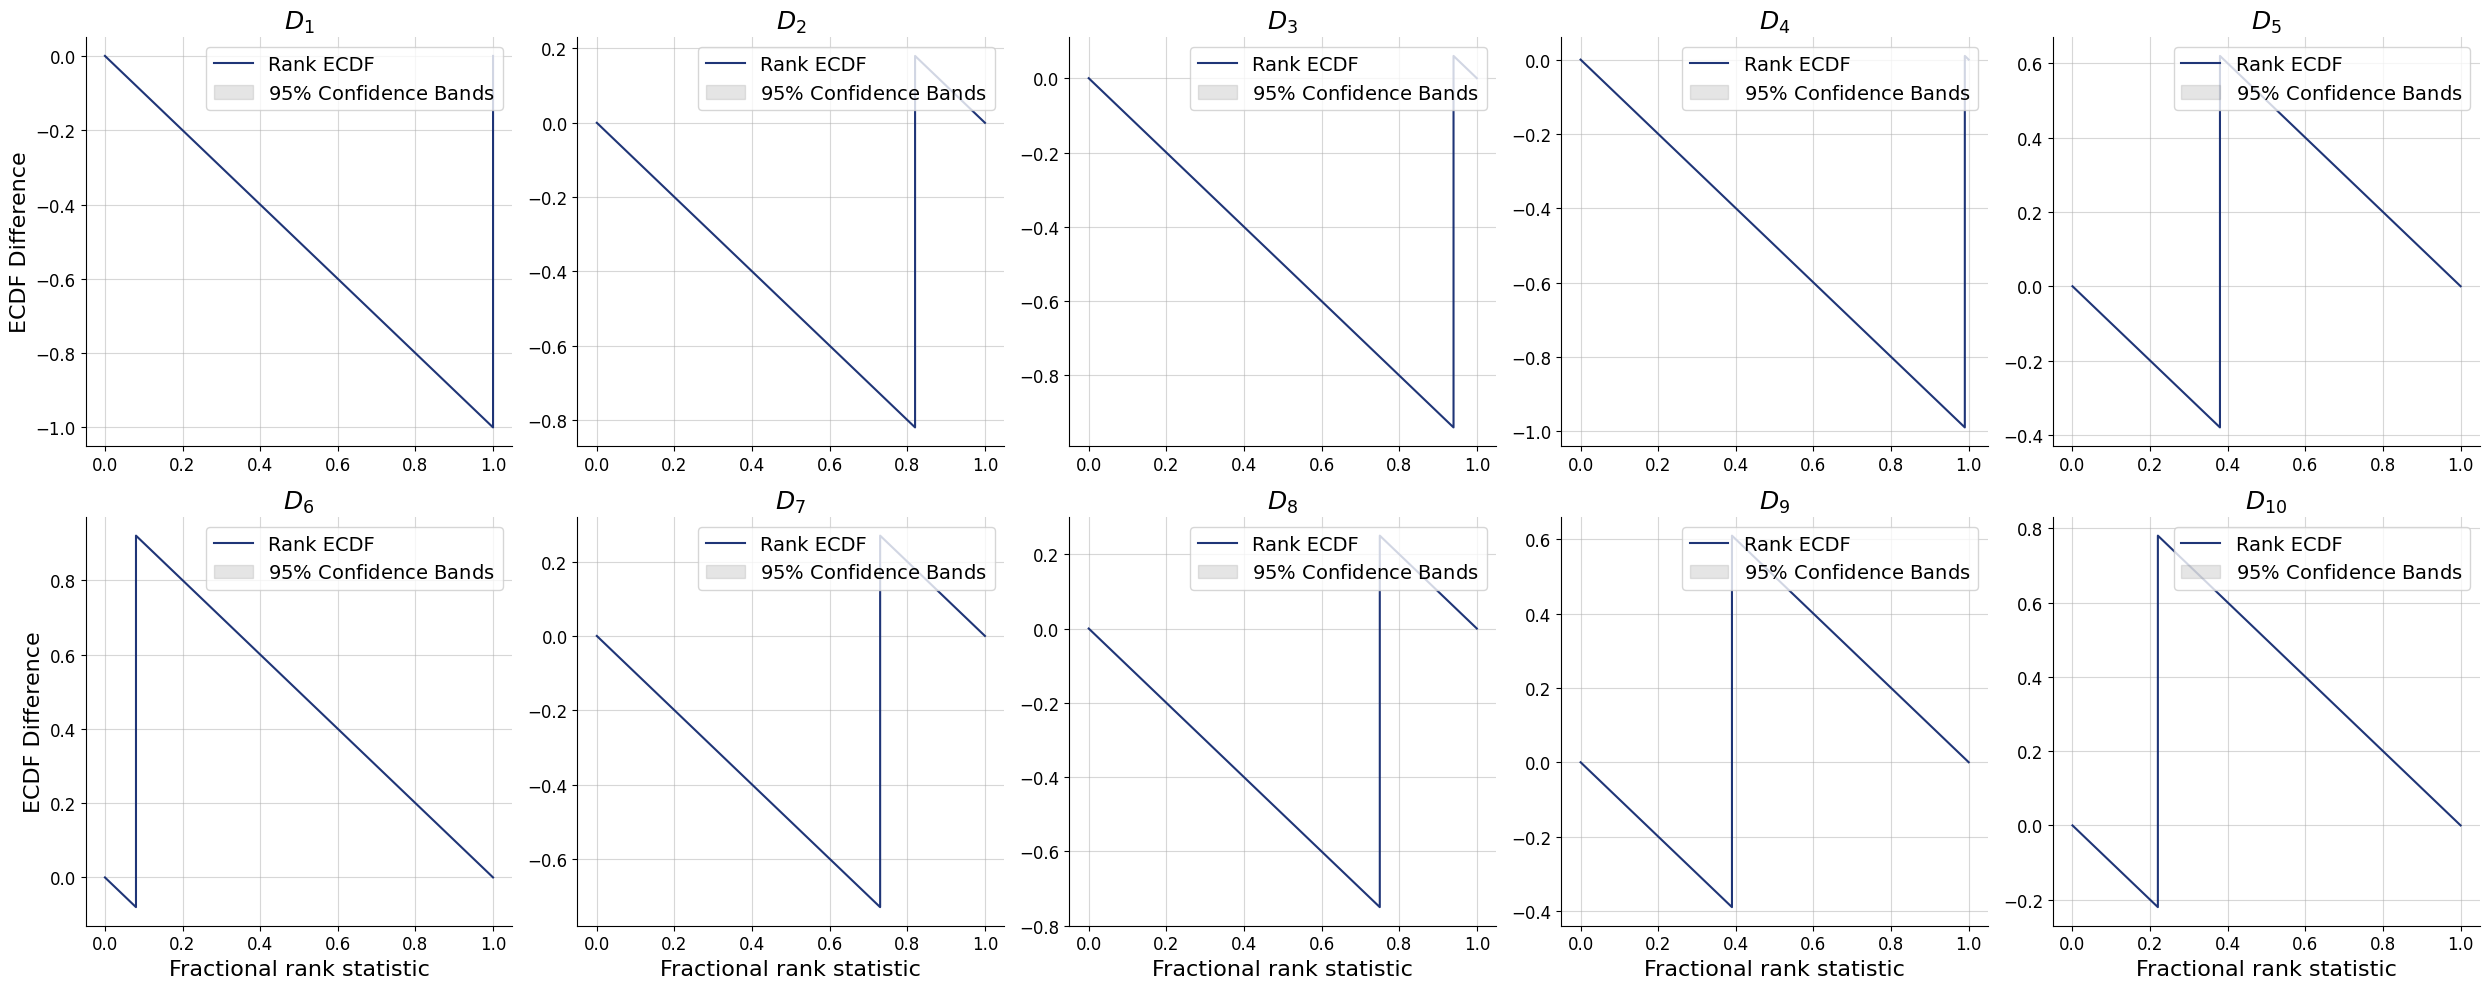

In [11]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                   difference=True, variable_names=param_names)

Data size: 10


100%|██████████| 10/10 [03:03<00:00, 18.31s/it]


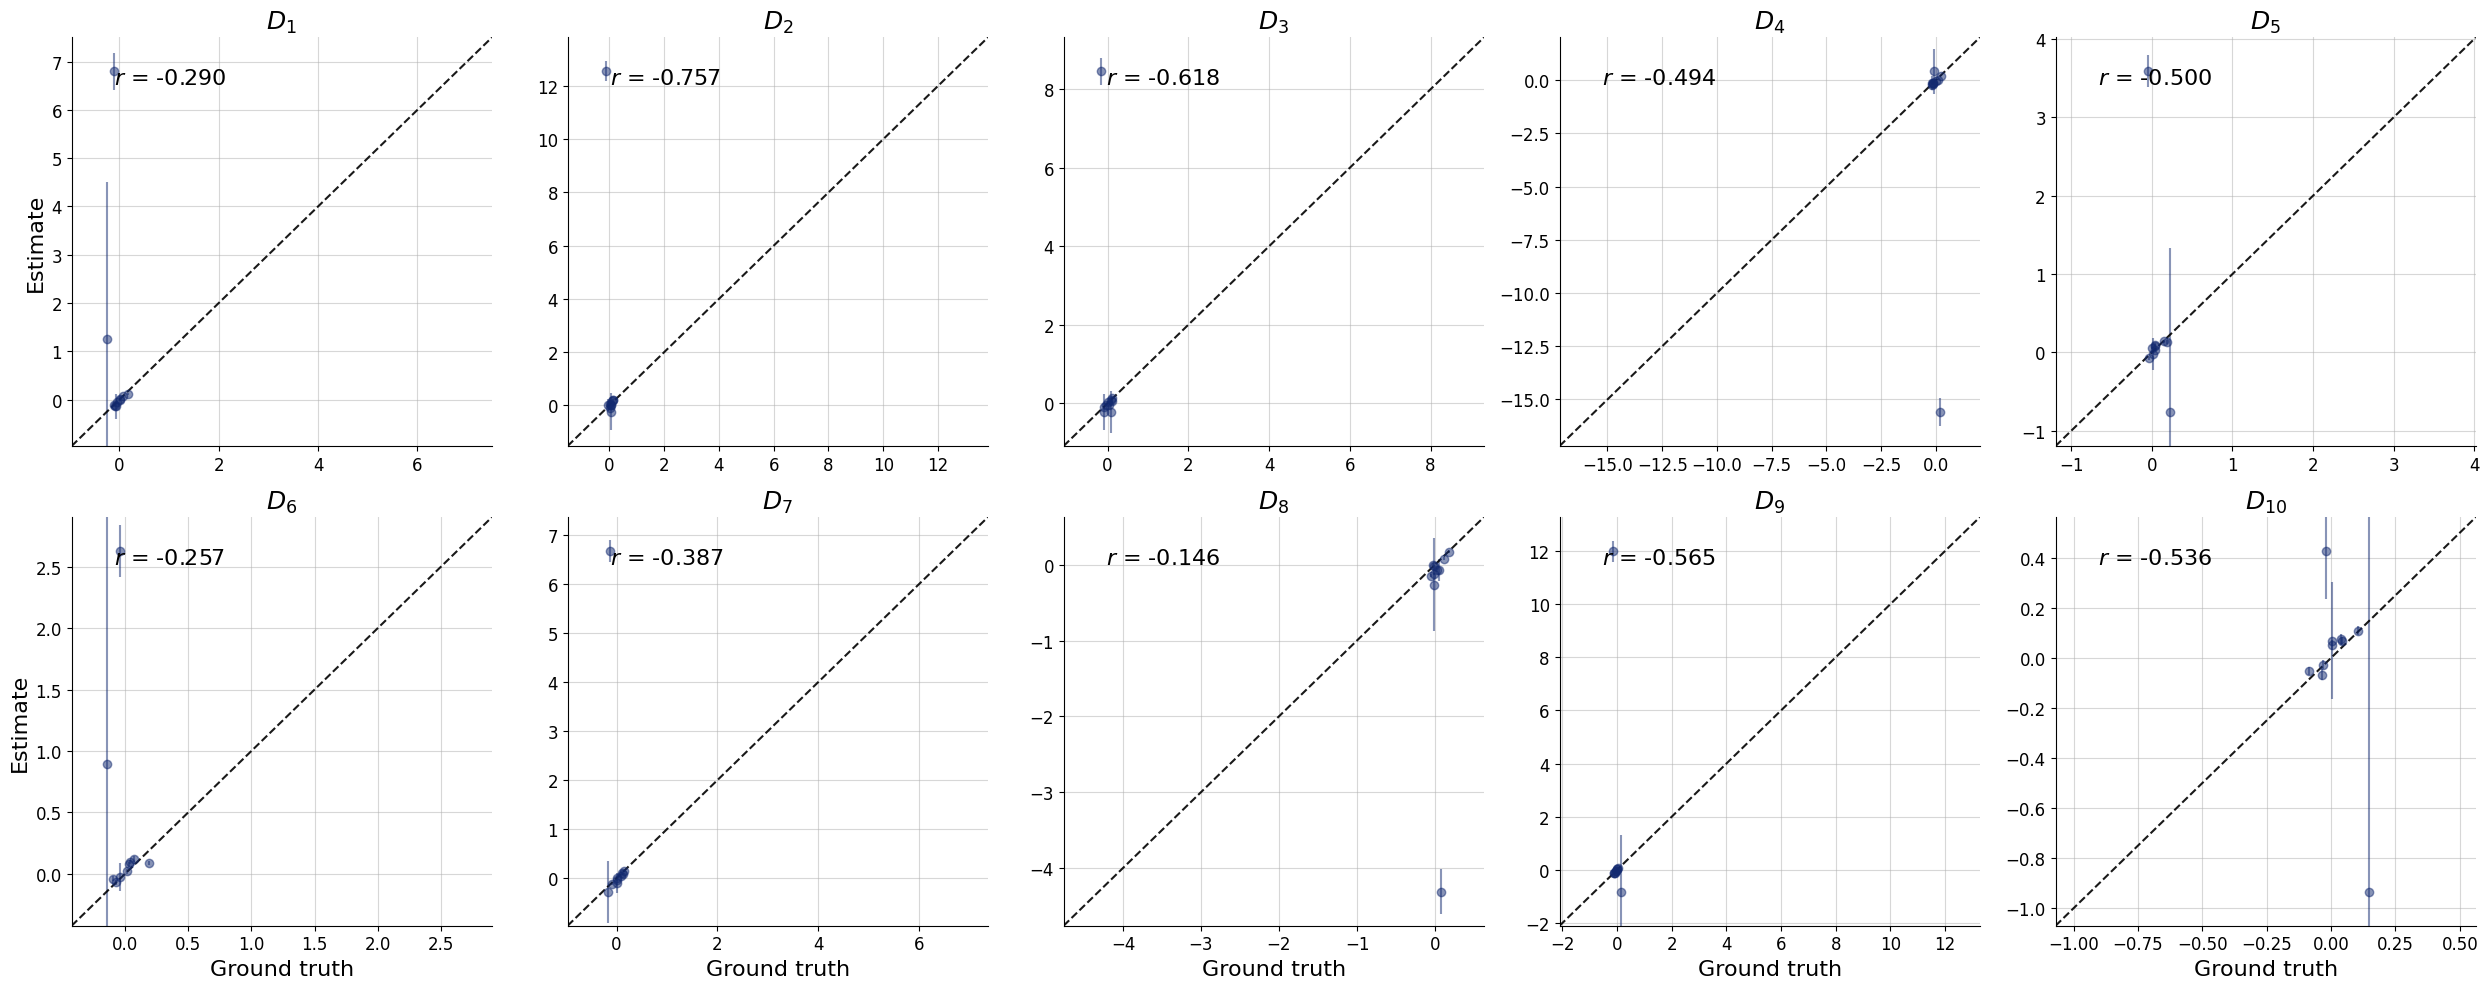

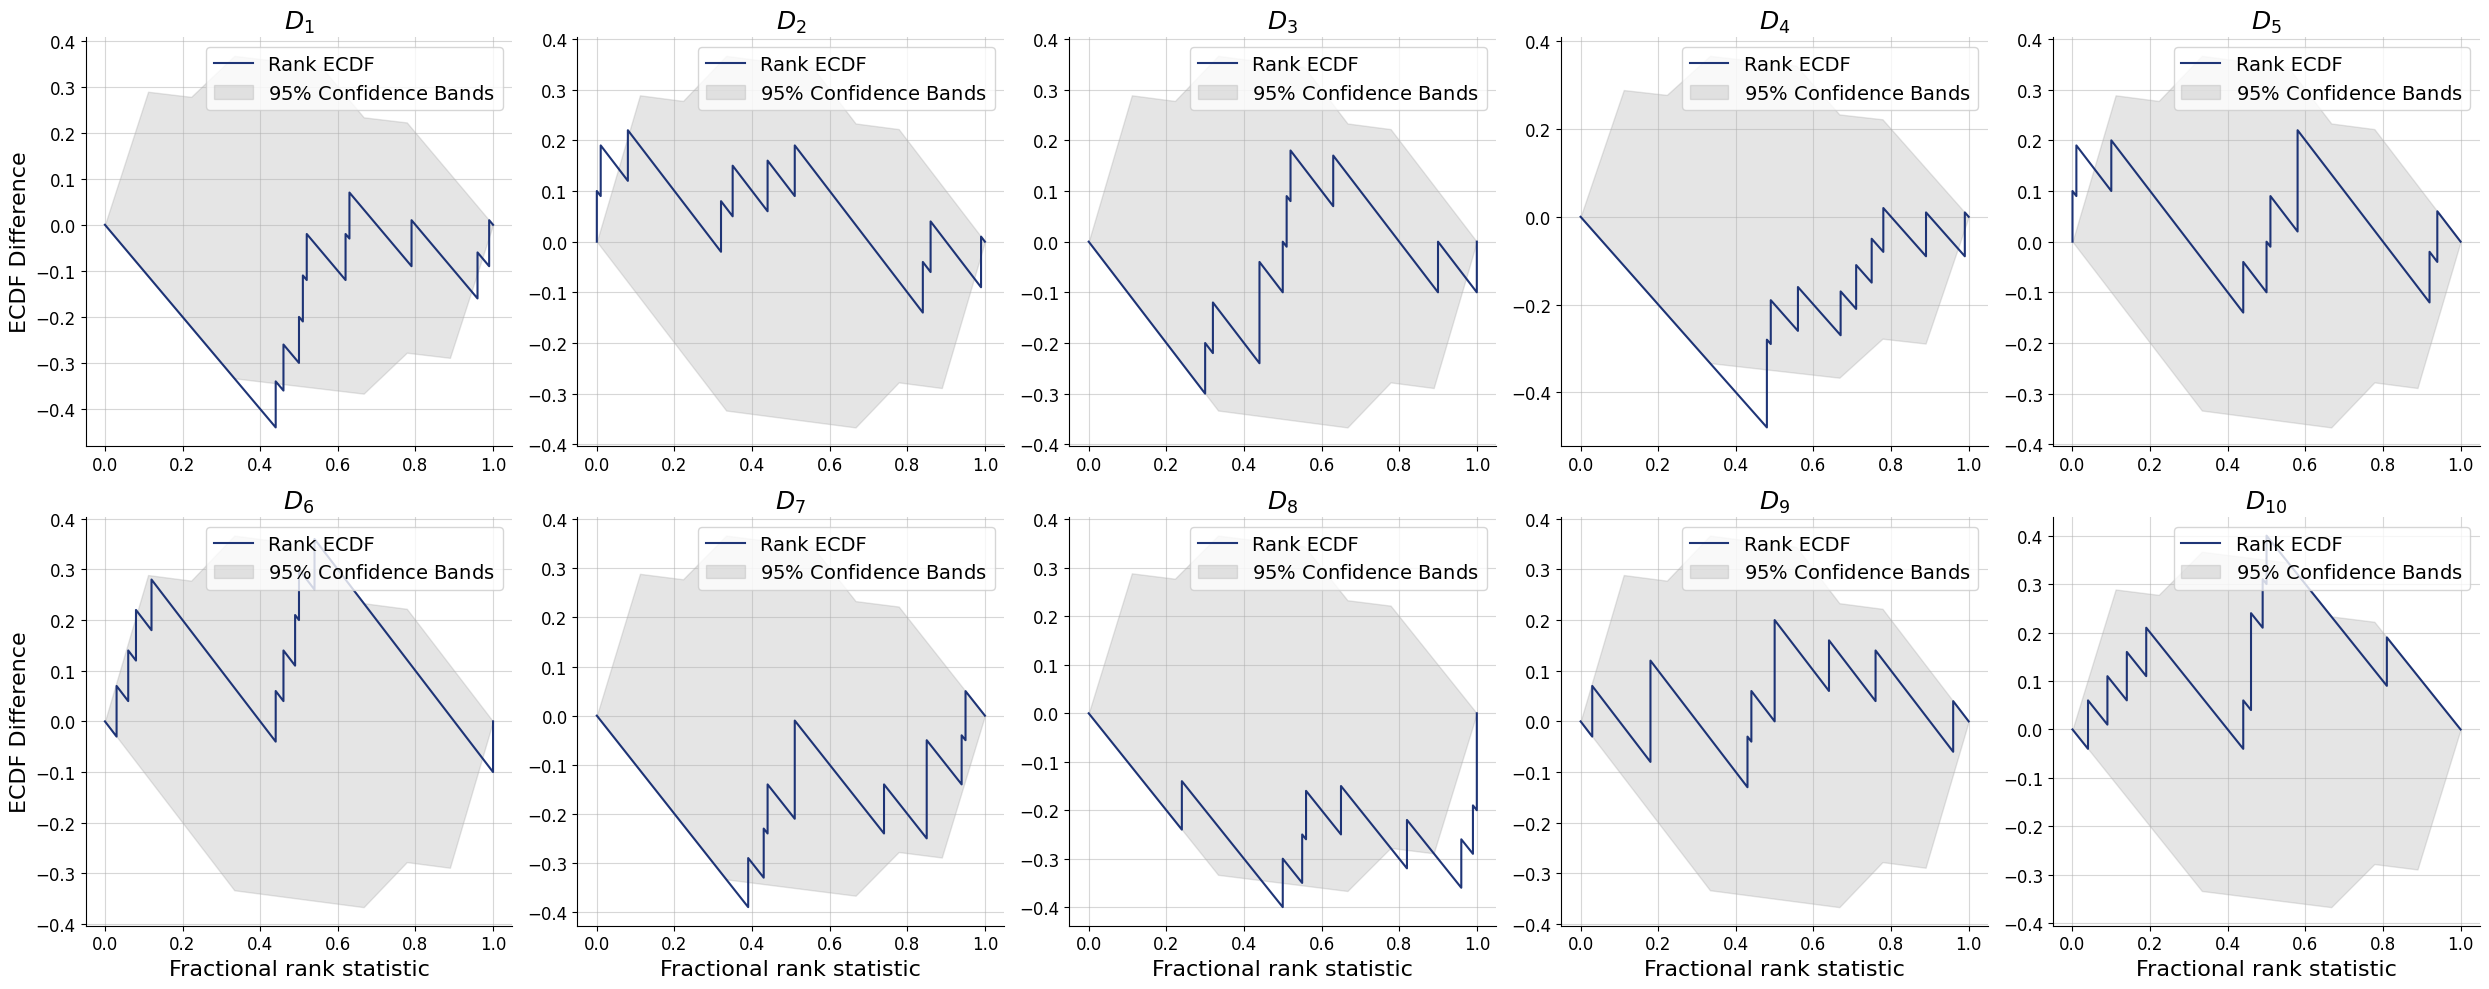

Data size: 100


  0%|          | 0/10 [00:00<?, ?it/s]/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/sbi/inference/potentials/score_fn_iid.py:663: UserWarning: Capping max_sampling_batch_size from 10000 to 1000 to avoid excessive memory usage.
  thetas = posterior.sample_batched(
100%|██████████| 10/10 [28:35<00:00, 171.52s/it]


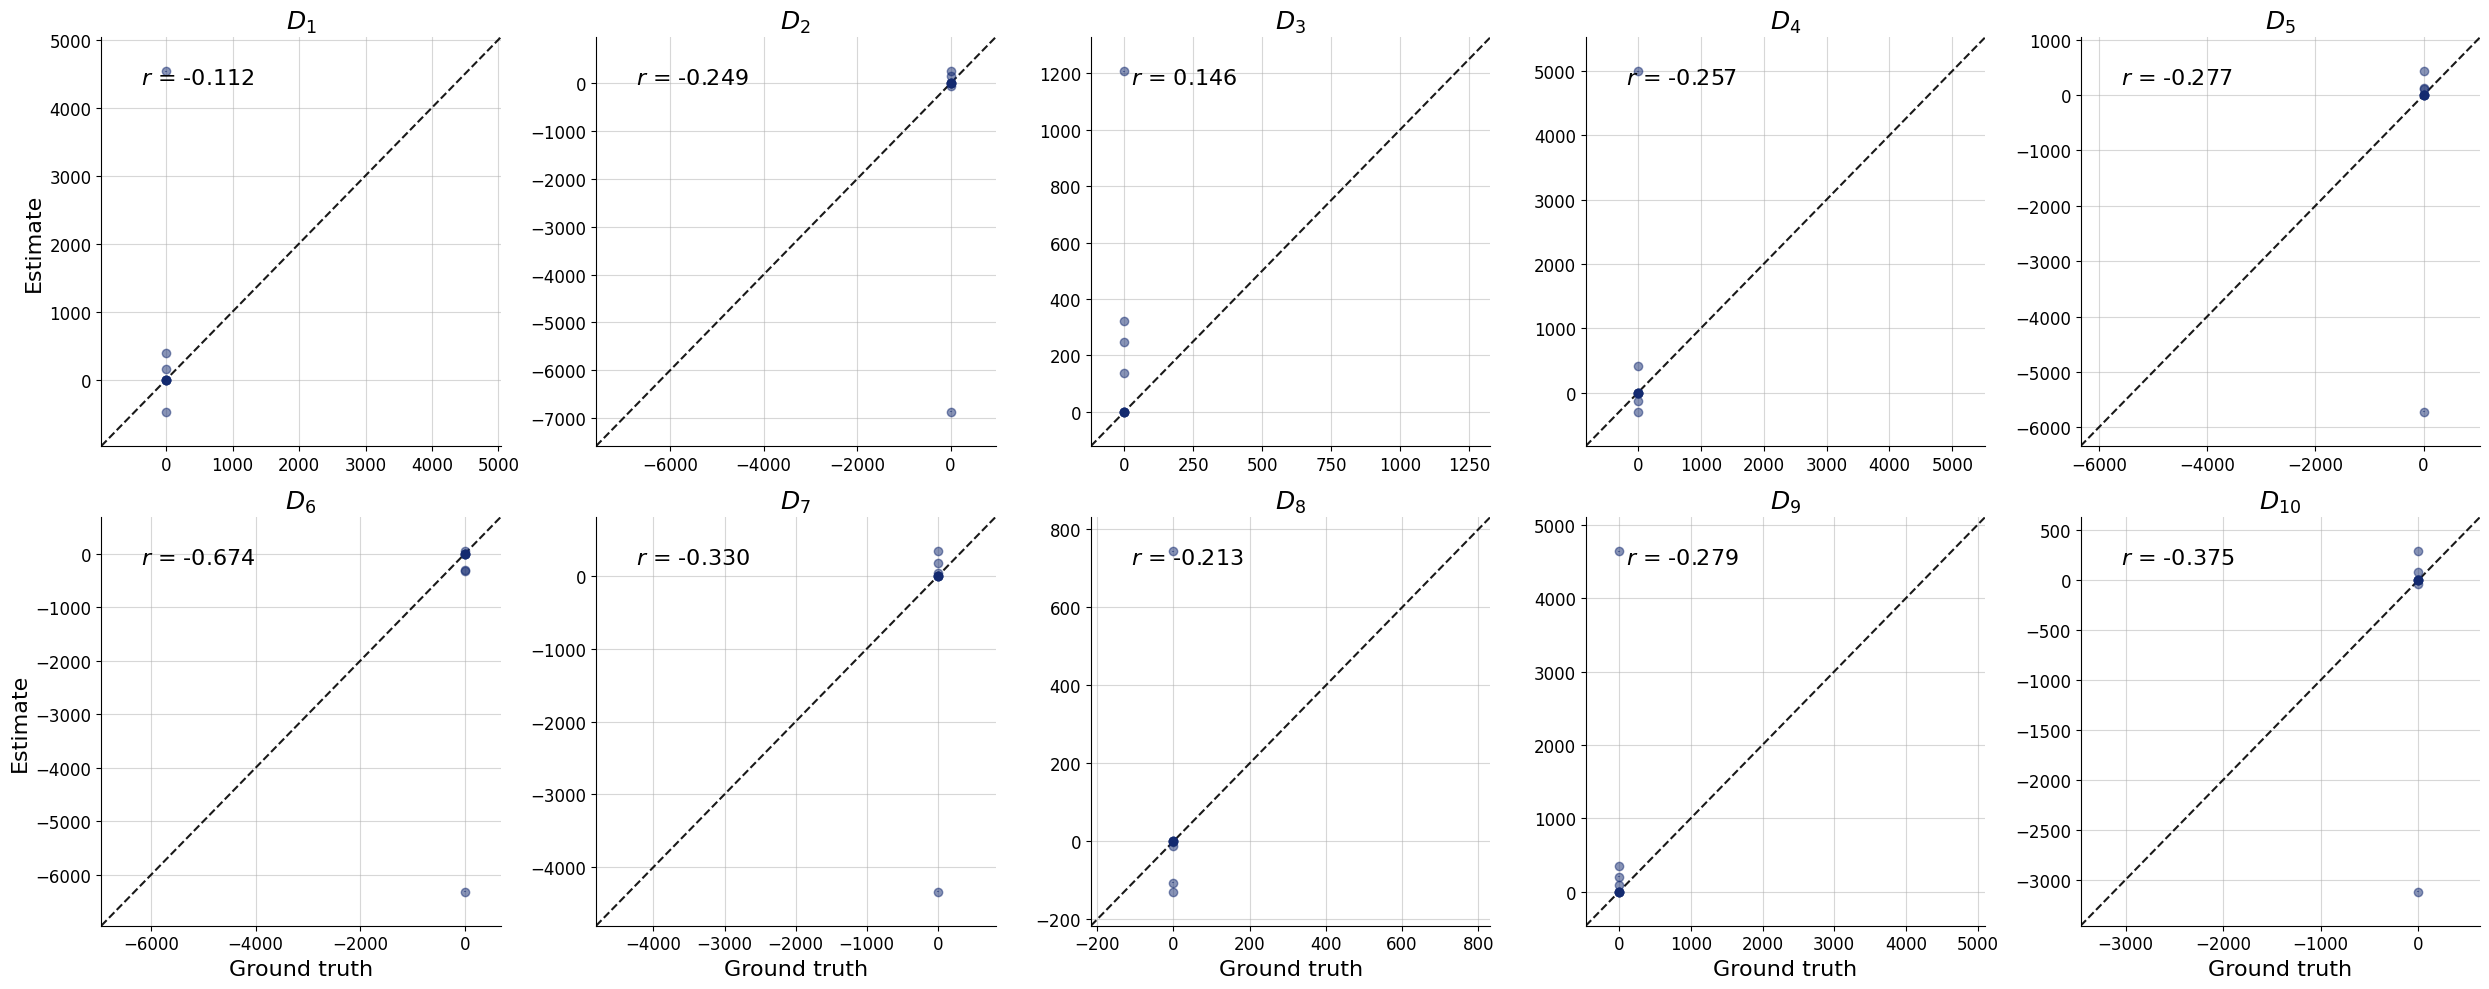

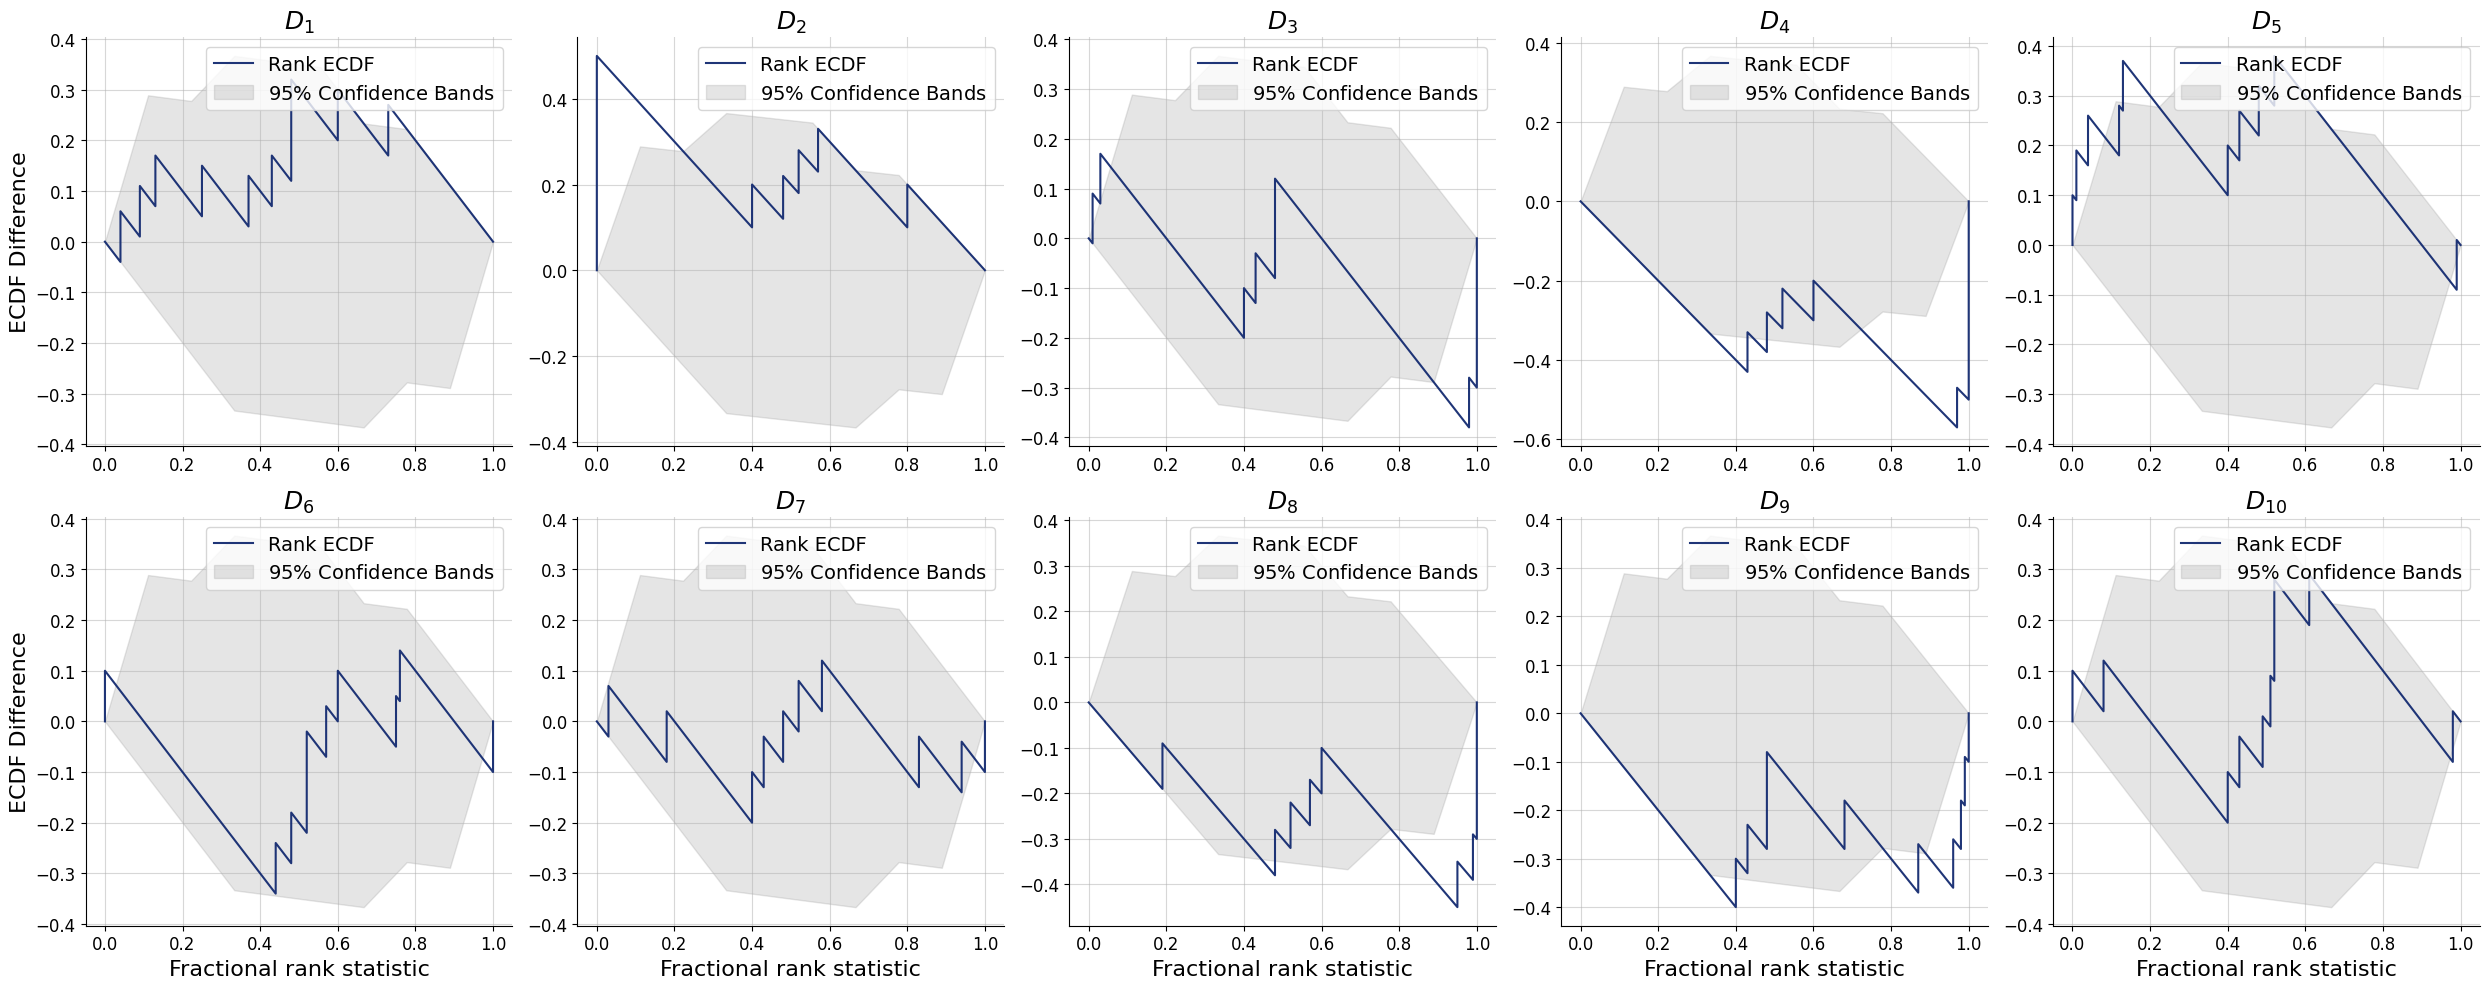

Data size: 10000


  0%|          | 0/10 [00:00<?, ?it/s]/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/sbi/inference/potentials/score_fn_iid.py:663: UserWarning: Capping max_sampling_batch_size from 10000 to 10 to avoid excessive memory usage.
  thetas = posterior.sample_batched(
  0%|          | 0/10 [4:50:12<?, ?it/s]


RuntimeError: All samples NaN after diffusion sampling. This may indicate numerical instability in the vector field.

In [12]:
for ds in [10, 100, 10000, 100000]:
    print('Data size:', ds)
    valid_prior_global, valid_data = generate_synthetic_data(prior, n_samples=10, data_size=ds,
                                                             normalize=False, random_seed=0)
    posterior_global_samples_valid = tall_data_sampling(valid_data, n_samples=n_post_samples)
    fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
    fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                       difference=True, variable_names=param_names)
    plt.show()